$V(x)=\sum_{t=0}^\infty \gamma^t R(x(t))$ \
where  $R(x)=Constant-\|x-x_{goal}\|>0$ \
and $\gamma=0.5$

# Create Environment

In [145]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from tqdm import tqdm

global N

N=50

global M
M=10

global T
global target
T=15
target=np.array([3,2])
global w
w=np.pi*2/23.7

global delta_t
delta_t=T/N

global beta
beta=[1]

global num_system
num_system=1

In [146]:
def Z(vecs, u, v):
    output=[]
    for i in range(num_system):
        vec=vecs[i]
        x=vec[0]
        y=vec[1]
        theta=vec[2]
        output.append([beta[i]*np.cos(theta)*u,beta[i]*np.sin(theta)*u,beta[i]*v])
    return np.array(output)

#check the correctness of Z
'''
x = np.linspace(0, 6.5, 1001)
plt.plot(x, Z(x))
plt.xlabel('Angle [rad]')
plt.ylabel('Z(theta)')
plt.grid()
plt.show()
'''

"\nx = np.linspace(0, 6.5, 1001)\nplt.plot(x, Z(x))\nplt.xlabel('Angle [rad]')\nplt.ylabel('Z(theta)')\nplt.grid()\nplt.show()\n"

In [147]:
def next_step(vecs,action):  
    u=action[0]
    v=action[1]
   
    for j in range(M):
        vecs_new=[]
        diff=Z(vecs,u,v)
        for i in range(num_system):
            w=vecs[i]+delta_t/M*diff[i]
            '''
            if w[2]>np.pi:
                w[2]-=2*np.pi
            if w[2]<-np.pi:
                w[2]+=2*np.pi
            '''
            vecs_new.append(w)
        vecs=np.array(vecs_new)
    return vecs

def observe(vecs):
    mu_x=0
    mu_y=0
    mu_theta=0
    var_x=0
    var_y=0
    for i in range(num_system):
        mu_x+=vecs[i][0]
        mu_y+=vecs[i][1]
        mu_theta+=vecs[i][2]
        var_x+=vecs[i][0]**2
        var_y+=vecs[i][1]**2
    var_x-=mu_x**2/num_system
    var_y-=mu_y**2/num_system
    
    w=np.array([mu_x,mu_y,mu_theta,var_x,var_y])/num_system
    
    if w[2]>np.pi:
        w[2]-=2*np.pi
    if w[2]<-np.pi:
        w[2]+=2*np.pi
   
    return w

def reward(obs):
    return max(100-(obs[0]-target[0])**2-(obs[1]-target[1])**2,0)

def reward_raw(position):
    r=0
    for i in range(num_system):
        r+=np.linalg.norm(position[i,[0,1]]-target)
    return r



# Learning Settings

In [148]:
global lr
lr=0.7
global eps
eps=0.1
global max_u
max_u=2
global precision
precision=0.0002
global action_set
action_set=np.array([[1,np.pi/4],[-1,np.pi/4],[1,0],[-1,0],[1,-np.pi/4],[-1,-np.pi/4]])

def exploration():
    a=np.random.uniform()
    if a<eps:
        return True
    else:
        return False

def find_max(cand):
    return np.argmax(cand)
    
def decide_u(theta,cand,std,init=False):
    explo=exploration()
    #print("cand",cand.shape)
    #print("std",std.shape)
    if init:
        return(np.random.randint(6)), True
    elif explo:
        return(find_max(std)), True
    else:
        return(find_max(cand)), False
    
def generate_history_pred(gp_list,history):
    cand=[]
    for j in range(len(gp_list)):
        pred=gp_list[j].predict(history.reshape(-1,5), return_std=False).reshape(-1,1)
        if j==0:
            cand=pred
        else:
            cand=np.concatenate((cand,pred),axis=1)
    output=[]
    for j in range(history.shape[0]):
        output.append([np.max(cand[j])])
    return np.array(output)
        
    
def decide_u_exploitation(theta,cand,init=False):
    return find_max(cand)


def trainingset_refine(history_su,history_su_next, history_r, num=1000):
    if history_su.shape[0]<num:
        return history_su, history_su_next, history_r
    else:
        history_su=history_su[-num:-1]
        history_su_next=history_su_next[-num:-1]
        history_r=history_r[-num:-1]
        return history_su,history_su_next,history_r


history_su=[0 for i in range(6)]
history_r=[0 for i in range(6)]
history_su_next=[0 for i in range(6)]
flags=[True for i in range(6)]

# Simulation


In [149]:
num_iter=100

position_result=[]
observation_result=[]
gpr_list=[]

best_r=-10000
best_obs=[]
best_pos=[[] for i in range(5)]
best_u=[]

for iterr in tqdm(range(num_iter)):
    #initialize
    position=np.array([[-2,-2,0],[-2,-2,0],[-2,-2,0],[-2,-2,0],[-2,-2,0]])
    observation=observe(position)
    u_t=[]
    observation_t=[observation]
    position_t=[[] for i in range(5)]
    
    
    for time in range(N+1):
        if iterr==0:
            candidates_u=[]
            std=[]
            u_k, _ = decide_u(observation,np.array(candidates_u),np.array(std),init=True)
            position_new = next_step(position,action_set[u_k])
            observation_new = observe(position_new)
            r = reward(observation_new)
            
            if flags[u_k]:
                history_su[u_k] = observation.reshape(-1,5)
                history_su_next[u_k] = observation_new.reshape(-1,5)  
                history_r[u_k] = np.array([r])
                flags[u_k]=False
            else:
                history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
                history_su_next[u_k] = np.concatenate((history_su_next[u_k], observation_new.reshape(-1,5)))
                history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            
            observation=observation_new
            position=position_new
            u_t.append(u_k)
            observation_t.append(observation)
            for i in range(num_system):
                position_t[i].append(position[i])
            
            
        else:            
            candidates_u=[]
            std=[]
            for i in range(6):
                cand, var = gpr_list[i].predict(observation.reshape(-1,5), return_std=True)
                candidates_u.append(cand[0])
                std.append(var[0])
            #print(candidates_u)
            #print(var)
            u_k, explo = decide_u(observation,np.array(candidates_u),np.array(std))
            position_new = next_step(position,action_set[u_k])
            observation_new = observe(position_new)
            r = reward(observation_new)
            #if r>0.1:
            if explo:
                history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
                history_su_next[u_k] = np.concatenate((history_su_next[u_k], observation_new.reshape(-1,5)))
                history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            else:
                a=np.random.uniform()
                if a<0.25:
                    history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
                    history_su_next[u_k] = np.concatenate((history_su_next[u_k], observation_new.reshape(-1,5)))
                    history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            
            observation=observation_new
            position=position_new
            u_t.append(u_k)
            observation_t.append(observation)
            for i in range(num_system):
                position_t[i].append(position[i])
            
            if time%((N+1)//3+1)==0:
                for i in range(6):
                    history_target=history_r[i].reshape(-1,1)+0.5*generate_history_pred(gpr_list,history_su_next[i])
                    gpr_list[i]=GaussianProcessRegressor(alpha=1e-6).fit(history_su[i], history_target)
                
                '''
                for i in range(6):
                    hist_su, hist_su_next, hist_r = trainingset_refine(history_su[i],history_su_next[i], history_r[i])
                    history_target=hist_r.reshape(-1,1)+0.01*generate_history_pred(gpr_list,hist_su_next)
                    gpr_list[i]=GaussianProcessRegressor(alpha=1e-4).fit(hist_su, history_target)
                '''
            '''
            if r>100-0.03:
                break
            '''
            
    if iterr==0:
        for i in range(6):
            gpr_list.append(GaussianProcessRegressor(alpha=1e-6).fit(history_su[i], history_r[i].reshape(-1,1)))
    else:       
        for i in range(6):
            history_target=history_r[i].reshape(-1,1)+0.5*generate_history_pred(gpr_list,history_su_next[i])
            gpr_list[i]=GaussianProcessRegressor(alpha=1e-6).fit(history_su[i], history_target)
            #print(history_su[i].shape[0])
        '''
        for i in range(6):
            hist_su, hist_su_next, hist_r = trainingset_refine(history_su[i],history_su_next[i], history_r[i])
            history_target=hist_r.reshape(-1,1)+0.01*generate_history_pred(gpr_list,hist_su_next)
            gpr_list[i]=GaussianProcessRegressor(alpha=1e-4).fit(hist_su, history_target)
            print(history_su[i].shape[0])
        '''
            
    print("observation =",observation)
    #print(observation_t)
    position_result.append(position)
    observation_result.append(observation)
    if r>best_r:
        best_r=r
        best_obs=observation_t
        best_pos=position_t
        best_u=u_t
    
    #print(history_su.shape)
    #print(u_t)

  2%|█▋                                                                                | 2/100 [00:00<00:08, 11.28it/s]

observation = [-1.0330064  -2.24903071 -1.17809725  0.          0.        ]
observation = [-1.93201821 -1.35830987 -0.23561945  0.          0.        ]


  4%|███▎                                                                              | 4/100 [00:00<00:11,  8.51it/s]

observation = [-0.70485497 -2.35704209 -0.9424778   0.          0.        ]
observation = [-1.33610445 -1.63242025 -2.59181394  0.          0.        ]


  6%|████▉                                                                             | 6/100 [00:00<00:12,  7.39it/s]

observation = [-1.09772953 -1.37064341 -1.17809725  0.          0.        ]
observation = [-0.8286743  -1.1940333  -1.17809725  0.          0.        ]


  8%|██████▌                                                                           | 8/100 [00:01<00:14,  6.56it/s]

observation = [-0.06799764  2.78431528 -1.88495559  0.          0.        ]
observation = [-0.4673158   8.30888772 -1.64933614  0.          0.        ]


 10%|████████                                                                         | 10/100 [00:01<00:14,  6.14it/s]

observation = [ 0.34643461  7.39737709 -1.17809725  0.          0.        ]
observation = [-1.57977474  8.58650514 -0.9424778   0.          0.        ]


 12%|█████████▋                                                                       | 12/100 [00:01<00:14,  6.09it/s]

observation = [ 0.2964167   7.13427506 -1.17809725  0.          0.        ]
observation = [ 0.31299308  4.76313816 -0.9424778   0.          0.        ]


 14%|███████████▎                                                                     | 14/100 [00:02<00:14,  6.06it/s]

observation = [-0.24654163  3.91809339 -1.88495559  0.          0.        ]
observation = [ 0.4283609   3.2525403  -2.12057504  0.          0.        ]


 16%|████████████▉                                                                    | 16/100 [00:02<00:14,  5.97it/s]

observation = [-3.36393101  8.45340278 -0.9424778   0.          0.        ]
observation = [-0.31097795  2.75799208 -1.64933614  0.          0.        ]


 18%|██████████████▌                                                                  | 18/100 [00:02<00:13,  5.87it/s]

observation = [ 1.01357561  4.15060676 -1.88495559  0.          0.        ]
observation = [ 0.21475614  2.57976105 -1.64933614  0.          0.        ]


 19%|███████████████▍                                                                 | 19/100 [00:02<00:14,  5.77it/s]

observation = [-2.76651513  5.94402418 -0.9424778   0.          0.        ]
observation = [-0.58183733 -1.4268741  -0.23561945  0.          0.        ]


 22%|█████████████████▊                                                               | 22/100 [00:03<00:14,  5.57it/s]

observation = [ 2.02804912 -1.7625491  -1.64933614  0.          0.        ]
observation = [ 1.31059856 -3.20132231  2.98451302  0.          0.        ]


 24%|███████████████████▍                                                             | 24/100 [00:03<00:13,  5.46it/s]

observation = [ 2.01270562 -2.80257011 -1.88495559  0.          0.        ]
observation = [ 1.80237204 -2.11011539 -1.64933614  0.          0.        ]


 25%|████████████████████▎                                                            | 25/100 [00:04<00:14,  5.33it/s]

observation = [ 0.79762592 -2.73533539 -2.59181394  0.          0.        ]
observation = [ 0.41126977 -1.02148059  0.4712389   0.          0.        ]


 27%|█████████████████████▊                                                           | 27/100 [00:04<00:14,  5.10it/s]

observation = [ 7.83060270e-01 -1.14790584e+00  4.85722573e-17  0.00000000e+00
  0.00000000e+00]
observation = [ 0.8443032  -3.09905044 -2.82743339  0.          0.        ]


 30%|████████████████████████▎                                                        | 30/100 [00:05<00:12,  5.43it/s]

observation = [-0.0837332   0.51138531 -0.70685835  0.          0.        ]
observation = [ 1.82723056  0.16153751 -0.70685835  0.          0.        ]


 32%|█████████████████████████▉                                                       | 32/100 [00:05<00:12,  5.37it/s]

observation = [ 1.58412653 -0.19769338 -0.23561945  0.          0.        ]
observation = [ 1.09223518  0.56308874 -0.4712389   0.          0.        ]


 34%|███████████████████████████▌                                                     | 34/100 [00:05<00:12,  5.34it/s]

observation = [ 4.74366704 -0.68759487 -3.06305284  0.          0.        ]
observation = [ 1.26359479  0.65632129 -0.4712389   0.          0.        ]


 36%|█████████████████████████████▏                                                   | 36/100 [00:06<00:11,  5.40it/s]

observation = [ 2.05426415 -2.48554581 -2.59181394  0.          0.        ]
observation = [ 2.44909514 -2.07775136 -2.82743339  0.          0.        ]


 38%|██████████████████████████████▊                                                  | 38/100 [00:06<00:11,  5.29it/s]

observation = [1.08110574e+00 2.87091668e-01 6.24500451e-17 0.00000000e+00
 0.00000000e+00]
observation = [ 1.93735487  0.49613531 -0.4712389   0.          0.        ]


 39%|███████████████████████████████▌                                                 | 39/100 [00:06<00:11,  5.24it/s]

observation = [ 4.6080091   0.67420766 -2.12057504  0.          0.        ]
observation = [ 2.10357792  0.56983463 -0.23561945  0.          0.        ]


 41%|█████████████████████████████████▏                                               | 41/100 [00:07<00:11,  5.06it/s]

observation = [-2.40982576  2.78370282 -0.23561945  0.          0.        ]
observation = [ 0.9713761   1.09847664 -0.4712389   0.          0.        ]


 44%|███████████████████████████████████▋                                             | 44/100 [00:07<00:11,  4.87it/s]

observation = [ 1.53250415  0.35499413 -0.23561945  0.          0.        ]
observation = [ 2.41884984  0.31614779 -0.70685835  0.          0.        ]


 45%|████████████████████████████████████▍                                            | 45/100 [00:07<00:11,  4.81it/s]

observation = [ 3.74938741  1.20210865 -0.70685835  0.          0.        ]


 46%|█████████████████████████████████████▎                                           | 46/100 [00:08<00:11,  4.72it/s]

observation = [ 3.50133809  0.76717265 -0.9424778   0.          0.        ]


 47%|██████████████████████████████████████                                           | 47/100 [00:08<00:11,  4.45it/s]

observation = [ 2.41270052  0.58574938 -0.23561945  0.          0.        ]


 48%|██████████████████████████████████████▉                                          | 48/100 [00:08<00:11,  4.36it/s]

observation = [-2.37760086  5.16146972 -0.70685835  0.          0.        ]


 49%|███████████████████████████████████████▋                                         | 49/100 [00:08<00:11,  4.35it/s]

observation = [3.33997633e+00 1.37401197e+00 4.85722573e-17 0.00000000e+00
 0.00000000e+00]


 50%|████████████████████████████████████████▌                                        | 50/100 [00:09<00:11,  4.30it/s]

observation = [2.71815463e+00 1.30695295e+00 4.85722573e-17 0.00000000e+00
 0.00000000e+00]


 51%|█████████████████████████████████████████▎                                       | 51/100 [00:09<00:11,  4.17it/s]

observation = [3.37257038 0.96568303 0.23561945 0.         0.        ]


 52%|██████████████████████████████████████████                                       | 52/100 [00:09<00:12,  3.83it/s]

observation = [0.51903815 1.87238168 0.23561945 0.         0.        ]


 53%|██████████████████████████████████████████▉                                      | 53/100 [00:10<00:13,  3.61it/s]

observation = [3.28350910e+00 1.03686215e+00 4.85722573e-17 0.00000000e+00
 0.00000000e+00]


 54%|███████████████████████████████████████████▋                                     | 54/100 [00:10<00:13,  3.39it/s]

observation = [ 3.34619682  0.81158048 -0.70685835  0.          0.        ]


 55%|████████████████████████████████████████████▌                                    | 55/100 [00:10<00:14,  3.16it/s]

observation = [ 3.271516    0.8294033  -0.70685835  0.          0.        ]


 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:11<00:14,  3.12it/s]

observation = [ 3.02111037  1.50486203 -0.70685835  0.          0.        ]


 57%|██████████████████████████████████████████████▏                                  | 57/100 [00:11<00:13,  3.17it/s]

observation = [ 0.78133263  3.47085788 -0.4712389   0.          0.        ]


 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:11<00:13,  3.07it/s]

observation = [2.49766746 2.20361395 0.23561945 0.         0.        ]


 59%|███████████████████████████████████████████████▊                                 | 59/100 [00:12<00:13,  2.98it/s]

observation = [ 2.02830525  2.08402792 -0.23561945  0.          0.        ]


 60%|████████████████████████████████████████████████▌                                | 60/100 [00:12<00:13,  2.91it/s]

observation = [ 2.37239163  1.65680333 -0.4712389   0.          0.        ]


 61%|█████████████████████████████████████████████████▍                               | 61/100 [00:12<00:13,  2.82it/s]

observation = [ 0.24099861  3.14012224 -0.4712389   0.          0.        ]


 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:13<00:13,  2.77it/s]

observation = [3.19422964 1.47513054 0.23561945 0.         0.        ]


 63%|███████████████████████████████████████████████████                              | 63/100 [00:13<00:12,  2.88it/s]

observation = [ 1.79587106  2.01072875 -0.4712389   0.          0.        ]


 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:13<00:12,  2.84it/s]

observation = [ 2.20915949  1.93840609 -0.70685835  0.          0.        ]


 65%|████████████████████████████████████████████████████▋                            | 65/100 [00:14<00:12,  2.69it/s]

observation = [ 2.80183344  1.72393688 -0.70685835  0.          0.        ]


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:14<00:12,  2.64it/s]

observation = [3.7639618  1.61747757 0.70685835 0.         0.        ]


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [00:15<00:12,  2.67it/s]

observation = [4.1170135  2.15341024 1.17809725 0.         0.        ]


 68%|███████████████████████████████████████████████████████                          | 68/100 [00:15<00:12,  2.64it/s]

observation = [4.27159561 1.96770357 0.9424778  0.         0.        ]


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [00:15<00:11,  2.63it/s]

observation = [ 3.22270523  1.32071499 -0.4712389   0.          0.        ]


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:16<00:11,  2.65it/s]

observation = [ 2.44564027  2.22363635 -0.4712389   0.          0.        ]


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [00:16<00:11,  2.52it/s]

observation = [3.0629595  1.46898673 0.9424778  0.         0.        ]


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:17<00:11,  2.50it/s]

observation = [3.05431377 1.57760698 1.17809725 0.         0.        ]


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [00:17<00:10,  2.52it/s]

observation = [2.93485296 0.88779404 0.23561945 0.         0.        ]


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:17<00:10,  2.45it/s]

observation = [3.03206782 1.66612142 0.9424778  0.         0.        ]


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [00:18<00:09,  2.51it/s]

observation = [3.0226078 1.6532968 0.4712389 0.        0.       ]


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:18<00:09,  2.48it/s]

observation = [ 2.88626886  1.68762267 -0.23561945  0.          0.        ]


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [00:19<00:10,  2.27it/s]

observation = [ 2.33058559  1.9683254  -0.4712389   0.          0.        ]


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:19<00:09,  2.25it/s]

observation = [ 2.97284663  1.74218705 -0.23561945  0.          0.        ]


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [00:20<00:09,  2.30it/s]

observation = [3.39253784 2.12369034 0.70685835 0.         0.        ]


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:20<00:08,  2.34it/s]

observation = [3.48476439 2.02980889 0.70685835 0.         0.        ]


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [00:20<00:08,  2.26it/s]

observation = [3.40859853 2.09458951 0.9424778  0.         0.        ]


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:21<00:08,  2.17it/s]

observation = [3.25515738 2.26033542 0.23561945 0.         0.        ]


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [00:21<00:07,  2.13it/s]

observation = [2.79804142 2.65240637 1.41371669 0.         0.        ]


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:22<00:07,  2.16it/s]

observation = [2.98456233 1.81190918 0.4712389  0.         0.        ]


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [00:22<00:06,  2.15it/s]

observation = [2.92971863 1.79533307 0.4712389  0.         0.        ]


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [00:23<00:06,  2.16it/s]

observation = [3.02063586 2.53760051 0.70685835 0.         0.        ]


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [00:23<00:06,  2.16it/s]

observation = [2.99796771 2.54771835 0.9424778  0.         0.        ]


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:24<00:05,  2.08it/s]

observation = [2.84970583 1.91223689 0.23561945 0.         0.        ]


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [00:24<00:05,  1.98it/s]

observation = [ 2.59614172  2.20237224 -0.9424778   0.          0.        ]


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:25<00:05,  1.97it/s]

observation = [3.05280576 1.71635259 0.9424778  0.         0.        ]


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [00:25<00:04,  1.91it/s]

observation = [3.38520578 1.63317362 1.17809725 0.         0.        ]


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:26<00:04,  1.81it/s]

observation = [2.48896349 2.20457901 0.9424778  0.         0.        ]


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [00:27<00:03,  1.81it/s]

observation = [2.86243446 1.75261652 1.17809725 0.         0.        ]


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [00:27<00:03,  1.84it/s]

observation = [ 2.20462373  2.54865705 -0.70685835  0.          0.        ]


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [00:28<00:02,  1.85it/s]

observation = [2.88091981 1.86744108 0.9424778  0.         0.        ]


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:28<00:02,  1.86it/s]

observation = [2.95874882 1.81132372 1.17809725 0.         0.        ]


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [00:29<00:01,  1.84it/s]

observation = [2.89052361 1.87448421 0.9424778  0.         0.        ]


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [00:29<00:01,  1.82it/s]

observation = [3.9450083  1.85180684 1.17809725 0.         0.        ]


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [00:30<00:00,  1.78it/s]

observation = [ 2.61339968  2.47130633 -0.23561945  0.          0.        ]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.23it/s]

observation = [3.21452778 2.39678401 1.64933614 0.         0.        ]


# Results

## Last Control

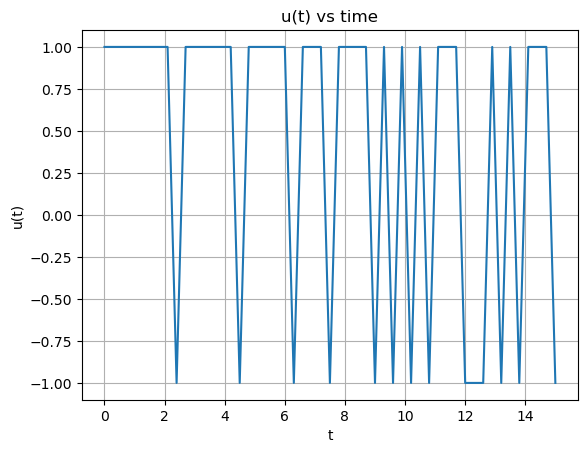

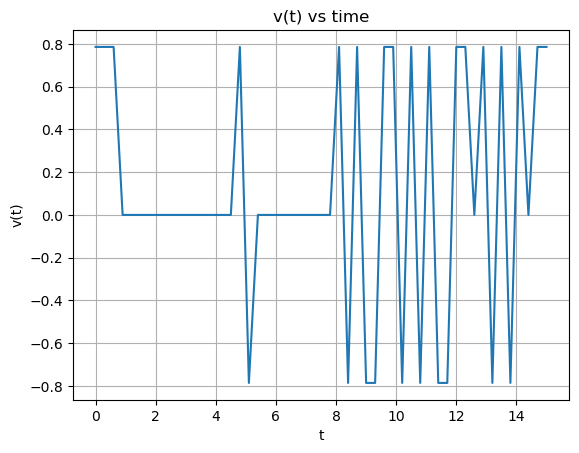

In [150]:
u=[2*(0.5-i%2) for i in u_t]
v=[(1-i//2)*np.pi/4 for i in u_t]

x = np.linspace(0, T, N+1)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, N+1)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

## Last Trajectory


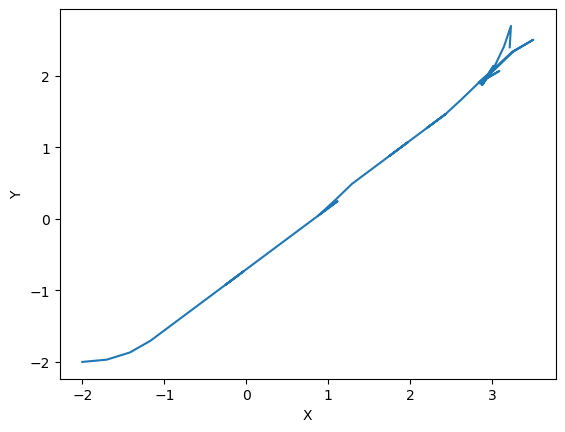

In [151]:
obs=np.array(observation_t)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

### End point and Goal

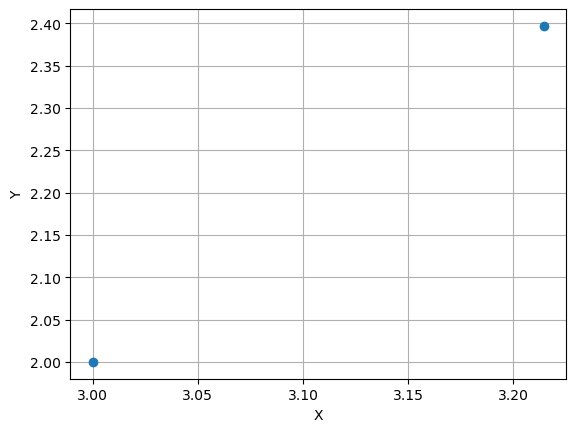

0.4510650937459622


In [152]:
pos=[]
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[:,[0,1]]
    #plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])

plt.plot(np.array([3,obs[-1,0]]),np.array([2,obs[-1,1]]), 'o')
#plt.plot(obs[-1,0],obs[-1,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()

print(reward_raw(np.array(pos)))

## Best Control

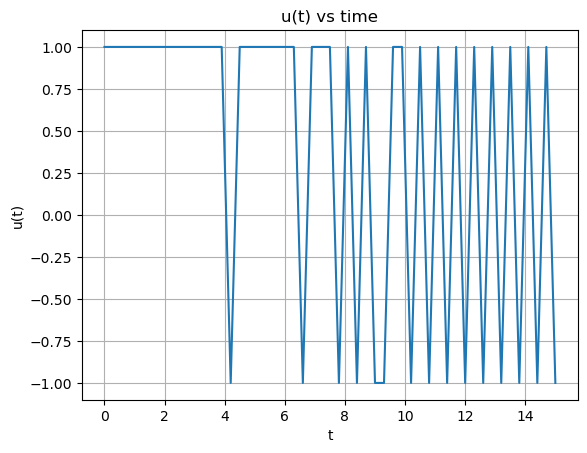

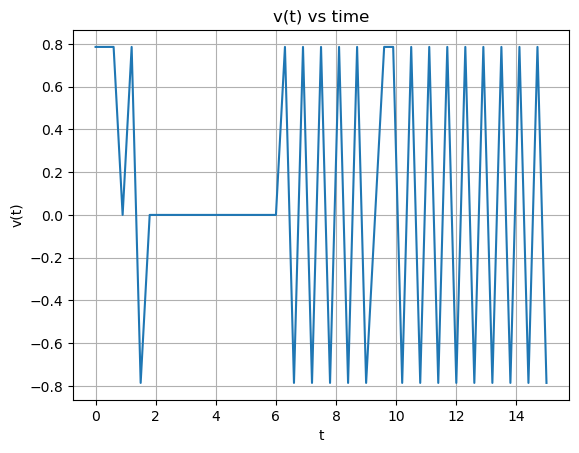

In [153]:
u=[2*(0.5-i%2) for i in best_u]
v=[(1-i//2)*np.pi/4 for i in best_u]

x = np.linspace(0, T, N+1)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, N+1)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

## Best Trajectory

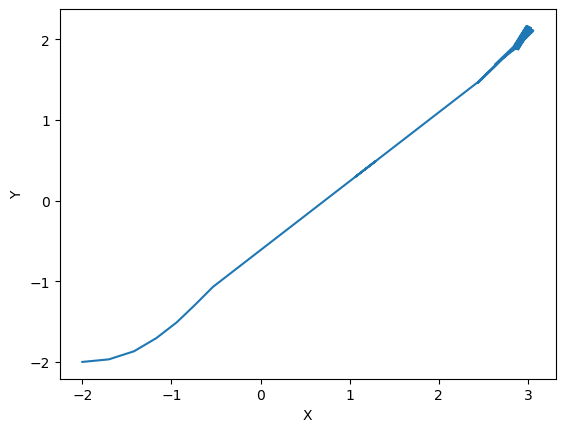

In [154]:
obs=np.array(best_obs)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

### End point and Goal

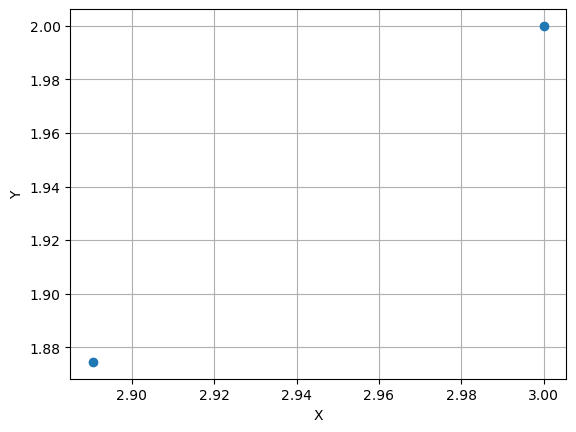

0.16655117343409134


In [155]:
pos=[]
for i in range(num_system):
    obs=np.array(best_pos[i])
    obs=obs[:,[0,1]]
    #plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])
    
plt.plot(np.array([3,obs[-1,0]]),np.array([2,obs[-1,1]]), 'o')
#plt.plot(obs[-1,0],obs[-1,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()

print(reward_raw(np.array(pos)))

## Pure Exploitation Control and Trajectory

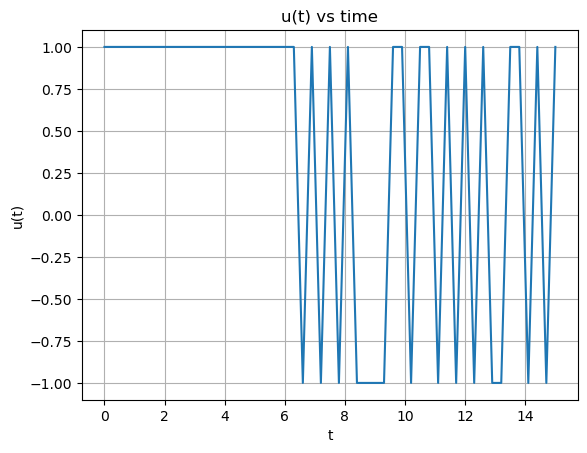

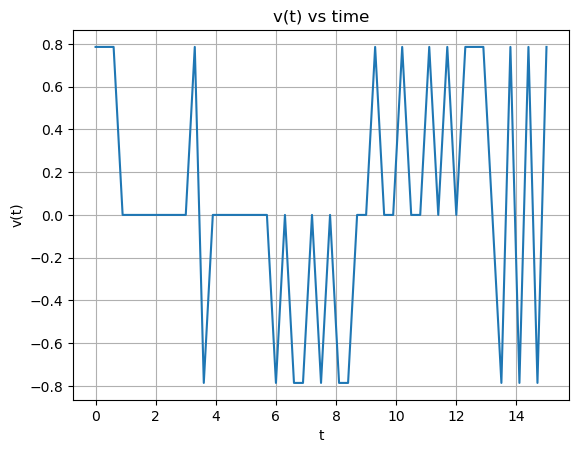

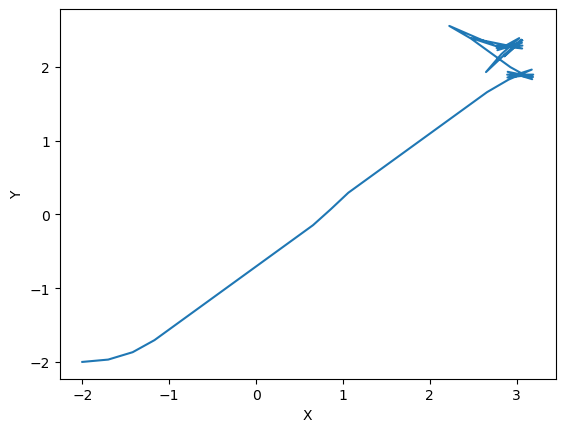

In [156]:
position=np.array([[-2,-2,0],[-2,-2,0],[-2,-2,0],[-2,-2,0],[-2,-2,0]])
observation=observe(position)
u_t=[]
observation_t=[observation]
position_t=[[] for i in range(5)]

for time in range(N+1):           
    candidates_u=[]
    for i in range(6):
        cand, _ = gpr_list[i].predict(observation.reshape(-1,5), return_std=True)
        candidates_u.append(cand[0])
    #print(candidates_u)
    u_k = decide_u_exploitation(observation,np.array(candidates_u))
    position_new = next_step(position,action_set[u_k])
    observation_new = observe(position_new)
    r = reward(observation_new)
    '''
    if explo:
        history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
        history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
    '''
    observation=observation_new
    position=position_new
    u_t.append(u_k)
    observation_t.append(observation)
    for i in range(num_system):
        position_t[i].append(position[i])
    '''
    if time%((N+1)//3+1)==0:
        for i in range(6):
            gpr_list[i]=GaussianProcessRegressor(alpha=1e-8).fit(history_su[i], history_r[i].reshape(-1,1))
    
    if r>100-0.03:
        break
    '''
u=[2*(0.5-i%2) for i in u_t]
v=[(1-i//2)*np.pi/4 for i in u_t]


x = np.linspace(0, T, N+1)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, N+1)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

obs=np.array(observation_t)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

### End point and Goal

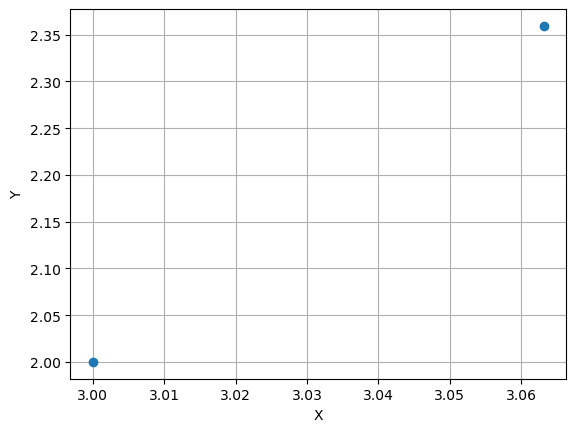

0.36479886364353004


In [157]:
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[:,[0,1]]
    #plt.plot(obs[:,0],obs[:,1])
    
plt.plot(np.array([3,obs[-1,0]]),np.array([2,obs[-1,1]]), 'o')
#plt.plot(obs[-1,0],obs[-1,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()

print(reward_raw(position))

In [158]:
print(observation_t[-1])
#print(position_t[-1][0])

[3.06313562 2.3592939  0.9424778  0.         0.        ]


In [159]:
a=[1,2,4,8]
a[1:3]

[2, 4]